# Training and evaluating a fully connected neural network for DNA sequences

## 1. Introduction

In this notebook, we use DNA sequences to build, train and evaluate a neural network.
The main use of this notebook is to demonstrate a typical workflow in PyTorch.
More specifically:

  - Loading a dataset
  - Create a neural network
  - Training a neural network
  - Evaluating the neural network on unseen data
  - Visualizing the performance
    
**Note:** To train the neural network on a GPU, you will have to make a few adjustments to the code (mainly when converting from a PyTorch tensor to a numpy array)

contact: lucas.davey@biscglobal.com

## 2. Load data

In [1]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score
from timeit import default_timer as timer
import datetime

# Specify what we will be working on 'cpu' or 'cuda' (GPU)
device = torch.device('cpu')

In [2]:
# Load data
my_dataset = pd.read_csv("dna_sequence_dataset.csv")

# Specificy data (X) and targets (y), since this is an example, we only use the first 50000 samples, decrease
# this number if training goes too slowly
X = my_dataset["dna_sequence"][:50000]
y = my_dataset["target"][:50000]

The dataset consists of DNA sequences with a binary target (0 or 1)

In [3]:
X.head()

0    AAAAAAAAAATA
1    AAAAAAAAAGAG
2    AAAAAAAAATCA
3    AAAAAAAAATTC
4    AAAAAAAACAAA
Name: dna_sequence, dtype: object

In [4]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

## 3. Create Dataset and DataLoader object

Before we can train our neural net, we need to split our dataset into a **training**, **validation** and **testing** set.

 - The training set is used to train our model (70% of dataset)
 - The validation set is used to determine the number of epochs that the model is trained for (10% of dataset)
 - The testing set is used to assess the model's performance on unseen data. (20% of dataset)
 
These percentages are not set in stone, but as a rule of thumb, we want to reserve most of the data for training.

The **Dataset_fcANN** class is a custom class that defines the data and target values (We will call this a sample from now on). 
This class has to be a child class from PyTorch's basic Dataset class and it should overwrite at least 
the **init**, **len** and **getitem** methods.

In this case, our custom dataset class simply converts the input DNA sequence into a binary matrix using the function **one_hot_sequence**, this matrix is then flattened and converted into a tensor (a multi-dimensional vector), and finally it is moved to the device (CPU or GPU).

In [5]:
def one_hot_sequence(seq):
    """Convert a DNA sequence into a binary matrix.
       
    Args:
        seq (str): input DNA sequence

    Returns:
        m (numpy array): binary matrix

    """
    d = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    length = len(seq)
    m = np.zeros((4, length), dtype='float32')
    for i, b in enumerate(seq):
        m[d[b]][i] = 1   
    return m

In [6]:
class Dataset_fcANN(Dataset):
    def __init__(self, X, y):
        "Initialization"
        self.X = X
        self.y = y
    
    def __len__(self):
        "Denotes the total number of samples"
        return len(self.X)

    def __getitem__(self, idx):
        "Generates one data and target pair"
        # Select DNA sequence at the position in the dataset specified by idx
        data = self.X.iloc[idx]
        
        # Convert the DNA sequence into a binary matrix
        data = one_hot_sequence(data)
        
        # Flatten the binary matrix and convert the numpy array into a PyTorch tensor
        data = torch.from_numpy(data.flatten())
            
        # Move the tensor to the device, depending on the loss function that you are using,
        # you may want to change the datatype 
        data = data.to(device, dtype=torch.float32)
        
        # Select the target value at the position in the dataset specified by idx, and convert into a numpy array
        target = np.array(self.y.iloc[idx])
        
        # Convert the numpy array into a PyTorch tensor
        target = torch.from_numpy(target)
        
        # Move the tensor to the device
        target = target.to(device, dtype=torch.long)
        
        # Return data and target tensors as a tuple
        return data, target

The **DataLoader** class defines how the samples are read by the neural network. We set the mini-batch size to 100, and we also set drop_last to True. drop_last ensures that if the last mini-batch of a dataset contains just 1 samples (i.e. number of samples % number of mini-batches = 1), then this data value is dropped so that no errors occur. I could calculate if it is necessary to do this for our example dataset, but since we have so many samples (), we can afford to drop one.

We enable shuffle to ensure that there is no bias in the data before we make a split, and stratify is used to make sure that the distribution of our target values (0 and 1) is the same for each split (training, validation and testing).

In [7]:
# Create testing set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, stratify=y)

# Create training and validation set (7/8th of 80% = 70%, and 1/8th of 80% = 10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=7/8, test_size=1/8, shuffle=True, stratify=y_train_val)

# Create dictionary with datasets for training, validation and testing set
datasets = {
    "train": Dataset_fcANN(X_train, y_train),
    "valid": Dataset_fcANN(X_val, y_val),
    "test": Dataset_fcANN(X_test, y_test)
}

# Set mini-batch size parameter
batch_size = 100

# Create dictionary with dataloaders for training, validation and testing set
dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True, drop_last=True),
    "valid": DataLoader(datasets["valid"], batch_size=batch_size, shuffle=True, drop_last=True),
    "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=True, drop_last=True)
}

## 4. Create fully-connect Artificial Neural Network

Next, we define the most important part of this notebook: the fully-connected artificial neural network. This neural network includes 1 input layer, 1 hidden layer, 1 output layer, and 2 batch normalization layers.
The output layer consists of 2 output nodes: one for each possible target value (0 or 1).

This neural network is encoded by the **fcANN** class, which is a child class from PyTorch's nn.Module class, and it has to define a **forward** method. This method describes one forward pass of a data value through the neural network.

In [8]:
class fcANN(nn.Module):
    def __init__(self, in_size=48, hidden_size=192, out_size=2, dropoutp=0.2, epochs=0):
        super(fcANN, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(in_size, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p=dropoutp)
        self.fc2 = nn.Linear(hidden_size, out_size)
        
        # Define number of epochs that the model has been trained for
        self.epochs = epochs

    def forward(self, x):
        x = self.dropout(F.relu(self.bn(self.fc1(x))))
        out = self.fc2(x)
        return out

## 5. Train neural network

To train the neural network, we use the custom **train** function. This function trains the neural network using the data in the dataloader dictionary that we created earlier. 
The neural network will be trained unless the loss doesnt decrease for max_epochs_stop consecutive epochs. In this case, the model will stop training (early stopping), and load the model with the lowest loss. 

 - To train the model so that it is guaranteed to have the lowest loss, the n_epochs should be high, and the max_epochs_stop low.

 - To train the model for a set amount of epochs, regardless if the final model has the lowest loss, the max_epochs_stop should be high.
 
**Note:** Everytime the validation loss decreases, the state dictionary of the model is saved to a file (save_file_name). Therefore, the state of the model with the lowest loss can always be retrieved from this file using (see [saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)).
 
**Note:** This specific function only works on a neural network for a binary classification problem.
More specifically, the neural network needs to have two output nodes (one for each value of the target), and the criterion should be the [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropy#torch.nn.CrossEntropyLoss).

**Note:** To reduce the output that is shown for each Epoch, you can comment lines 166, 167 or 168.

**Note:** Rerunning this function on the same model will result in a model that is trained more than once, eventhough it may seem as though it has been trained only once. This is because model.epochs is set to 0 before training, but the model weights are not reset.


In [9]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch neural network
    
       The model will be trained for n_epochs unless the the loss doesn't decrease for max_epochs_stop
       consecutive epochs. In that case, the training will be stopped early.
              
       This function is inspired by this notebook:
       https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb

    Args:
        model (PyTorch model): neural network to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of consecutive epochs with no improvement in validation loss
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns:
        model (PyTorch model): trained neural network
        metrics_dict (dict): dictionary containing all metrics that were tracked during training
        
    """
    ########################
    # Initialize variables #
    ######################## 
    
    # start timer
    overall_start = timer()
    
    # Set number of epochs that the model was trained for to 0
    model.epochs = 0
    
    # Initialize variable for tracking how many times that 
    # the loss has not lowered after one epoch of training
    epochs_no_improve = 0
    
    # Initialize variable for tracking the validation loss
    # We set this variable to +Infinity so that the first time that the model is trained, 
    # it will always be lower, and thus continue training
    valid_loss_min = np.Inf
    
    # Initialize variable for tracking if the training was stopped early
    early_stopping = False
    
    # Initialize dictionary for tracking different metrics
    # This dictionary should contain at least a "loss", "target", and "output" key
    metrics_dict = {'loss': {'train': [], 'valid': []},
                    'target': {'train': [], 'valid': []}, 
                    'output': {'train': [], 'valid': []},
                    'accuracy': {'train': [], 'valid': []},
                    'roc_auc': {'train': [], 'valid': []},
                    'pr_auc': {'train': [], 'valid': []}}
           
    for epoch in range(n_epochs):
                   
        # Initialize metrics to record a new epoch
        # We do this for both the training set and the validation set
        for mode in ['train', 'valid']:
            metrics_dict['loss'][mode].append(0)
            # Value is 2, because we have 2 nodes in the output layer (output is numpy array with length 2)
            metrics_dict['output'][mode].append(np.empty((0, 2))) 
            metrics_dict['target'][mode].append([])
            metrics_dict['accuracy'][mode].append([])
            metrics_dict['roc_auc'][mode].append([])
            metrics_dict['pr_auc'][mode].append([])

        # Set model to training
        model.train()
        start = timer()
        
        #################
        # Training loop #
        #################

        for mini_batch_number, (data, target) in enumerate(train_loader):

            # Clear gradients
            optimizer.zero_grad()
            
            # Predicted outputs
            output = model(data)
            
            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()
         
            # Multiply loss by number of examples in a minibatch
            metrics_dict['loss']['train'][-1] += loss.item() * len(target)

            # Append target and output to lists
            metrics_dict['target']['train'][-1] = np.append(metrics_dict['target']['train'][-1], target.data.cpu().numpy())
            metrics_dict['output']['train'][-1] = np.vstack((metrics_dict['output']['train'][-1], output.data.cpu().numpy()))
        
            # Print training completion percentage
            print(f'Epoch: {epoch+1}\t{100 * (mini_batch_number + 1) / len(train_loader):6.2f}% complete ({str(datetime.timedelta(seconds=round(timer() - start)))})', end='\r')
                
        ###################
        # Validation loop #
        ###################
        
        # Don't need to keep track of gradients
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            for data, target in valid_loader:
                                
                # Predicted outputs
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                
                # Multiply loss by number of examples in a minibatch and add to metrics dictionary
                metrics_dict['loss']['valid'][-1] += loss.item() * len(target)

                # Append target and output to lists and add to metrics dictionary
                metrics_dict['target']['valid'][-1] = np.append(metrics_dict['target']['valid'][-1], target)
                metrics_dict['output']['valid'][-1] = np.vstack((metrics_dict['output']['valid'][-1], output))
        
        # Count epochs that model was trained for
        model.epochs += 1
        
        #####################    
        # Calculate metrics #
        #####################
        
        # Loss over one epoch is the average of the loss over the entire dataset
        metrics_dict['loss']['train'][-1] /= len(train_loader.dataset)
        metrics_dict['loss']['valid'][-1] /= len(valid_loader.dataset)

        # At the end of the validation loop, we can calculate metrics to be added to metrics dictionary 
        for mode in ['train', 'valid']:

            # Add accuracy to the metrics dictionary       
            pred = np.argmax(metrics_dict['output'][mode][-1], axis=1) # Convert output probability to 0 or 1
            target = metrics_dict['target'][mode][-1]
            correct = (pred == target)
            metrics_dict['accuracy'][mode][-1] = sum(correct) / len(correct)

            # Add ROC AUC to the metrics dictionary
            fpr, tpr, _ = roc_curve(metrics_dict['target'][mode][-1], 
                                    metrics_dict['output'][mode][-1][:, 1]) # select positive class
            metrics_dict['roc_auc'][mode][-1] = auc(fpr, tpr)

            # Add PR AUC to the metrics dictionary
            pr_auc = average_precision_score(metrics_dict['target'][mode][-1], 
                                             metrics_dict['output'][mode][-1][:, 1]) # select positive class
            metrics_dict['pr_auc'][mode][-1] = pr_auc
        
        # Print metrics
        output_str = [f'\n\t\tTraining loss: {metrics_dict["loss"]["train"][-1]:.4f}\t\t\tValidation loss: {metrics_dict["loss"]["valid"][-1]:.4f}']
        
        # Print every n epochs (e.g. 2, print only even epochs)
        if (model.epochs) % print_every == 0:
            print(''.join(output_str)+'\n') 
        
        # If validation loss decreases, save model and go to next epoch
        if metrics_dict['loss']['valid'][-1] < valid_loss_min: # valid_loss_min is np.Inf for the first Epoch

            # Save model
            torch.save(model.state_dict(), save_file_name)

            # Track improvement
            epochs_no_improve = 0 # Reset tracker to 0 since the loss decreased
            best_epoch = epoch

            # Set the validation loss to the current validation loss
            valid_loss_min = metrics_dict['loss']['valid'][-1]

        # If validation loss increases, increment count of epochs with no improvement
        else:
            epochs_no_improve += 1
            
            # Trigger early stopping
            if epochs_no_improve >= max_epochs_stop:
                
                # Load the best model
                model.load_state_dict(torch.load(save_file_name))  
                model.epochs = best_epoch + 1
    
                early_stopping = True
        
                break   

    ########################
    # Report final metrics #
    ########################
    
    # Calculate time function took in total
    total_time = round(timer() - overall_start)
    total_time = str(datetime.timedelta(seconds=total_time))

    # Attach the optimizer
    model.optimizer = optimizer

    # Report final metrics
    if early_stopping:
        early_stopping_str = f'Early Stopping! Epochs trained: {model.epochs} ' 
    else:
        early_stopping_str = f'Epochs trained: {model.epochs} '  
    
    output_str = [f'{early_stopping_str}({total_time}), Best epoch: {best_epoch + 1}, with loss: {metrics_dict["loss"]["valid"][model.epochs-1]:.4f}']
    output_str.append(f'accuracy: {metrics_dict["accuracy"]["valid"][model.epochs-1]:.4f}')
    output_str.append(f'roc_auc: {metrics_dict["roc_auc"]["valid"][model.epochs-1]:.4f}')
    output_str.append(f'pr_auc: {metrics_dict["pr_auc"]["valid"][model.epochs-1]:.4f}')
    print(', '.join(output_str))

    return model, metrics_dict

Before we can train the model, we have to first define a **loss function**, and an **optimizer**.
As a loss function, we use the the CrossEntropyLoss. The optimizer is the type of gradient descent algorithm that we use (Adam is currently the best).

In [10]:
# Define model using default parameters
model = fcANN() 

criterion = nn.CrossEntropyLoss()

# lr is the learning rate, low = slower but more accurate learning, high = faster but less accurate learning
# 1e-3 is a good middle ground value
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Move model to cpu or gpu
model.to(device)

fcANN(
  (fc1): Linear(in_features=48, out_features=192, bias=True)
  (bn): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=192, out_features=2, bias=True)
)

In [11]:
model, metrics_dict = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=f'delete_me.pt',
    n_epochs=20,
    max_epochs_stop=2,
    print_every=1)

/home/ldavey/miniconda3/envs/ml/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch: 1	100.00% complete (0:00:02)
		Training loss: 0.4150			Validation loss: 0.3839

Epoch: 2	100.00% complete (0:00:02)
		Training loss: 0.3888			Validation loss: 0.3781

Epoch: 3	100.00% complete (0:00:02)
		Training loss: 0.3831			Validation loss: 0.3761

Epoch: 4	100.00% complete (0:00:02)
		Training loss: 0.3787			Validation loss: 0.3761

Epoch: 5	100.00% complete (0:00:02)
		Training loss: 0.3757			Validation loss: 0.3753

Epoch: 6	100.00% complete (0:00:02)
		Training loss: 0.3741			Validation loss: 0.3749

Epoch: 7	100.00% complete (0:00:02)
		Training loss: 0.3717			Validation loss: 0.3746

Epoch: 8	100.00% complete (0:00:02)
		Training loss: 0.3707			Validation loss: 0.3745

Epoch: 9	100.00% complete (0:00:02)
		Training loss: 0.3700			Validation loss: 0.3732

Epoch: 10	100.00% complete (0:00:02)
		Training loss: 0.3690			Validation loss: 0.3754

Epoch: 11	100.00% complete (0:00:02)
		Training loss: 0.3662			Validation loss: 0.3766

Early Stopping! Epochs trained: 9 (0:00:2

## 6. Visualize metrics

Next, we visualize the output using the metrics dictionary. The first function, is a function used to plot the progression of the

In [12]:
def plot_metric_per_epoch(metrics_dict, metric, model_epochs):
    """Plot training and validation metric per epoch using the metrics dictionary
    Args:
        metrics_dict (dict): dictionary containing all metrics that were tracked during training

    Returns:
        ax (matplotlib.axes object): plot showing metric per epoch
        
    """  
    assert metric in metrics_dict.keys()
    
    fig, ax = plt.subplots(1,1)
    for mode in ['train', 'valid']:
        ax.plot(range(1, len(metrics_dict[metric][mode]) + 1), metrics_dict[metric][mode], label=mode)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'Training and Validation {metric}')
    ax.axvline(model_epochs, linestyle='--', color='red', label='model epochs')
    ax.legend()
    return ax

<AxesSubplot:title={'center':'Training and Validation loss'}, xlabel='Epochs', ylabel='Loss'>

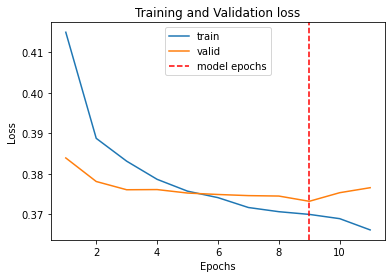

In [13]:
plot_metric_per_epoch(metrics_dict, 'loss', model.epochs)

<AxesSubplot:title={'center':'Training and Validation accuracy'}, xlabel='Epochs', ylabel='Accuracy'>

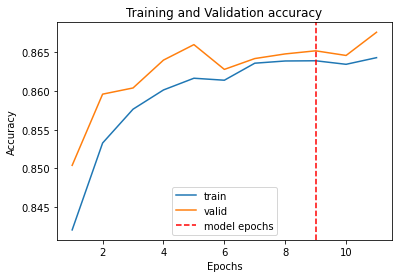

In [14]:
plot_metric_per_epoch(metrics_dict, 'accuracy', model.epochs)

<AxesSubplot:title={'center':'Training and Validation roc_auc'}, xlabel='Epochs', ylabel='Roc_auc'>

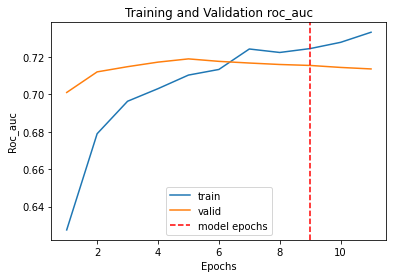

In [15]:
plot_metric_per_epoch(metrics_dict, 'roc_auc', model.epochs)

<AxesSubplot:title={'center':'Training and Validation pr_auc'}, xlabel='Epochs', ylabel='Pr_auc'>

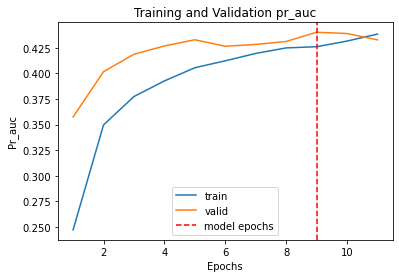

In [16]:
plot_metric_per_epoch(metrics_dict, 'pr_auc', model.epochs)

In [17]:
def plot_roc_curve(metrics_dict, epoch, mode):
    """Plot receiver operator characteristic curve using the metrics dictionary
    Args:
        metrics_dict (dict): dictionary containing all metrics that were tracked during training

    Returns:
        ax (matplotlib.axes object): plot showing receiver operator characteristic curve
        
    """
    assert mode in ["train", "valid", "test"], 'mode must be "train", "valid" or "test"'
    
    fig, ax = plt.subplots(1,1)
    fpr, tpr, _ = roc_curve(metrics_dict['target'][mode][epoch-1],
                            metrics_dict['output'][mode][epoch-1][:, 1]) # select positive class
    ax.plot(fpr, tpr, label=f'AUC = {metrics_dict["roc_auc"][mode][epoch-1]:2.2f}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC curve')
    ax.legend()
    return ax

<AxesSubplot:title={'center':'ROC curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

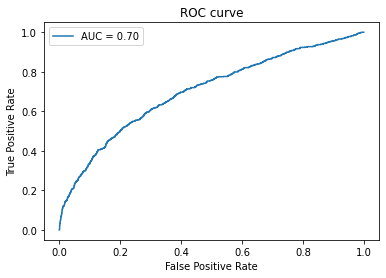

In [18]:
plot_roc_curve(metrics_dict, epoch=1, mode="valid")

In [19]:
def plot_pr_curve(metrics_dict, epoch=1, mode="valid"):
    """Plot precision recall using the metrics dictionary

    Args:
        metrics_dict (dict): dictionary containing all metrics that were tracked during training
        epoch (int): epoch to plot
        mode (str): 'valid' or 'train'

    Returns:
        ax (matplotlib.axes object): plot showing precision recall curve
        
    """
    assert mode in ["train", "valid", "test"], 'mode must be "train", "valid" or "test"'  
    
    fig, ax = plt.subplots(1,1)
    precision, recall, _ = precision_recall_curve(metrics_dict['target'][mode][epoch-1],
                                                  metrics_dict['output'][mode][epoch-1][:, 1]) # select positive class
    ax.step(precision, recall, label=f'AUC = {metrics_dict["pr_auc"][mode][epoch-1]:2.2f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'PR curve')
    ax.legend()
    return ax

<AxesSubplot:title={'center':'PR curve'}, xlabel='Recall', ylabel='Precision'>

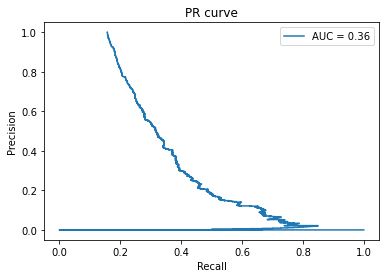

In [20]:
plot_pr_curve(metrics_dict, epoch=1, mode="valid")

In [21]:
def history_df(metrics_dict):
    """Create a dataframe using the metrics dictionary output
    Args:
        metrics_dict (dict): dictionary containing all metrics that were tracked during training
        
    Returns:
        df (pandas DataFrame): dataframe showing values of tracked metrics at each epoch
        
    """
    # Create empty dictionary
    df = dict()
    
    # Reformat dictionary
    for metric, v in metrics_dict.items():
        if metric not in ['output', 'target']:            
            for mode, epochs in v.items():                
                df[f'{mode} {metric}'] = epochs
    
    # Convert dictionary to dataframe
    df = pd.DataFrame(df, index = pd.Index(range(1, len(epochs) + 1)))
    
    return df  

In [22]:
history_df(metrics_dict)

,train loss,valid loss,train accuracy,valid accuracy,train roc_auc,valid roc_auc,train pr_auc,valid pr_auc
1,0.414960,0.383941,0.842057,0.8504,0.627487,0.701029,0.247084,0.357411
2,0.388778,0.378130,0.853286,0.8596,0.678956,0.712046,0.349581,0.401613
3,0.383145,0.376094,0.857657,0.8604,0.696335,0.714830,0.377339,0.418646
4,0.378667,0.376139,0.860143,0.8640,0.703067,0.717269,0.392573,0.426714
5,0.375746,0.375281,0.861657,0.8660,0.710333,0.719002,0.405457,0.432779
6,0.374146,0.374926,0.861400,0.8628,0.713345,0.717679,0.412216,0.426432
7,0.371711,0.374647,0.863600,0.8642,0.724294,0.716784,0.419415,0.428224
8,0.370680,0.374540,0.863886,0.8648,0.722433,0.716002,0.424819,0.431095
9,0.370014,0.373245,0.863914,0.8652,0.724520,0.715488,0.425975,0.440114
10,0.368960,0.375369,0.863457,0.8646,0.727859,0.714428,0.431480,0.438877


## 7. Evaluate model

In [23]:
def evaluate(model,
             test_loader):
    """Evaluate a PyTorch neural network

    Args:
        model (PyTorch model): neural network to test
        test_loader (PyTorch dataloader): test dataloader to iterate through

    Returns:
        metrics_dict (dict): dictionary containing all metrics that were tracked during testing
        
    """
    # Create metrics dictionary and initialize with empty values
    metrics_dict = {'target': {'test': [[]]}, 
                    'output': {'test': [np.empty((0, 2))]},
                    'accuracy': {'test': [[]]},
                    'roc_auc': {'test': [[]]},
                    'pr_auc': {'test': [[]]}}
    
    # Set to evaluation mode
    model.eval()
    
    with torch.no_grad():

        # Testing loop
        for data, target in test_loader:

            # Predicted outputs
            output = model(data)

            # Append target and output to lists
            metrics_dict['target']['test'][-1] = np.append(metrics_dict['target']['test'][-1], target.data.cpu().numpy())
            metrics_dict['output']['test'][-1] = np.vstack((metrics_dict['output']['test'][-1], output.data.cpu().numpy()))
            
        # Add accuracy to the metrics dictionary       
        pred = np.argmax(metrics_dict['output']['test'][-1], axis=1) # Convert output probability to 0 or 1
        correct = (pred == metrics_dict['target']['test'][-1])
        metrics_dict['accuracy']['test'][-1] = sum(correct) / len(correct)

        # Add ROC AUC to the metrics dictionary
        fpr, tpr, _ = roc_curve(metrics_dict['target']['test'][-1], metrics_dict['output']['test'][-1][:, 1]) # select positive class
        metrics_dict['roc_auc']['test'][-1] = auc(fpr, tpr)

        # Add PR AUC to the metrics dictionary
        metrics_dict['pr_auc']['test'][-1] = average_precision_score(metrics_dict['target']['test'][-1], metrics_dict['output']['test'][-1][:, 1]) # select positive class
        
        # Print metrics
        print(f"accuracy {metrics_dict['accuracy']['test'][-1]:.4f}, roc_auc {metrics_dict['roc_auc']['test'][-1]:.4f}, pr_auc {metrics_dict['pr_auc']['test'][-1]:.4f}")
        
    return metrics_dict

In [24]:
metrics_dict = evaluate(model, dataloaders['test'])

accuracy 0.8622, roc_auc 0.7078, pr_auc 0.4338


Using the functions that we defined earlier, we can visualize the final performance

In [25]:
history_df(metrics_dict)

,test accuracy,test roc_auc,test pr_auc
1,0.8622,0.70781,0.433831


<AxesSubplot:title={'center':'ROC curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

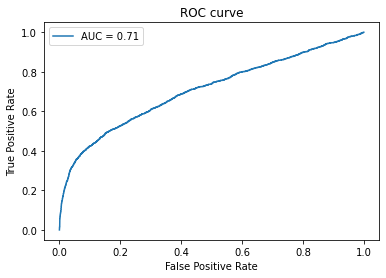

In [26]:
plot_roc_curve(metrics_dict, 1, 'test')

<AxesSubplot:title={'center':'PR curve'}, xlabel='Recall', ylabel='Precision'>

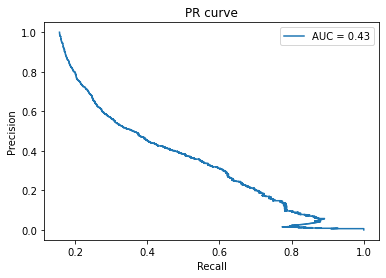

In [27]:
plot_pr_curve(metrics_dict, 1, 'test')